# VAR Model

Vector autoregressive models are used for multivariate time series analysis and forecasting.<br>
It works by looking back at a window of past observations for every variable in order to create <br>
a linear regression model for the prediction of each variable. For instance, a VAR model that has<br>
7 variables will create 7 different models, one for the forecasting of each variable. 

In [34]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

In [35]:
# import data
stationary = pd.read_csv('stationary_data_all.csv', index_col = 0)
stationary.tail()

,price,volatility,volume_price,volume_number,positive_comment,neutral_comment,negative_comment
Date,,,,,,,
2021-06-26,0.008797,0.071407,-0.098522,-1.278144e+06,259.0,131.0,122.0
2021-06-27,0.078638,0.085256,-0.037122,-1.233257e+06,257.0,112.0,111.0
2021-06-28,0.049665,0.084721,0.249261,2.219877e+06,218.0,103.0,87.0
2021-06-29,0.038261,0.076824,-0.027798,-7.842578e+05,303.0,141.0,144.0
2021-06-30,0.051317,0.084513,0.040008,-1.291487e+05,92.0,29.0,23.0


## train and fit var model

In [36]:
# stationary index to datetime
stationary.index = pd.DatetimeIndex(stationary.index).date

In [37]:
# pick start date for your analysis
# look at last step and see when data starts to be consistent
start_date = dt.date(2012, 1, 1)
stationary = stationary[start_date : ]
stationary.head()

,price,volatility,volume_price,volume_number,positive_comment,neutral_comment,negative_comment
2021-01-02,0.058715,0.088684,0.368800,6.795292e+06,153.0,93.0,53.0
2021-01-03,0.230695,0.240904,0.828421,2.084807e+07,328.0,220.0,143.0
2021-01-04,0.064242,0.231567,0.230996,8.408167e+06,224.0,133.0,100.0
2021-01-05,0.055871,0.129599,-0.315544,-1.698376e+07,194.0,114.0,78.0
2021-01-06,0.092915,0.120283,0.073413,-7.292737e+05,267.0,146.0,130.0


In [38]:
# create train data (80/20 split)
train = stationary[ : int(0.8*(len(stationary)))].copy()

In [39]:
# create VAR model on train data
model = VAR(endog = train)

/Users/sowmyareddy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [40]:
# see the different lag order suggestions to pick your information criterion
print(model.select_order(trend = 'c'))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 13, BIC -> 1, FPE -> 2, HQIC -> 1>


In [41]:
# fit model to train data
# model_fit is a VARResultsWrapper object
model_fit = model.fit(ic = 'aic', trend = 'c')
# number of lags
num_lag = model_fit.k_ar
num_lag

13

In [42]:
# model_fit summary
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Dec, 2021
Time:                     17:21:17
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    47.8642
Nobs:                     131.000    HQIC:                   39.4731
Log likelihood:          -2866.46    FPE:                4.77802e+15
AIC:                      33.7296    Det(Omega_mle):     1.15349e+14
--------------------------------------------------------------------
Results for equation price
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.017516         0.027631            0.634           0.526
L1.price                    -0.182801         0.219409           -0.833           0.405
L1.volatility                0.0

In [43]:
# example one day forecast into the future using train data
## IMPORTANT = data has to be in ndarray format. use '.values' on y argument ##
model_fit.forecast(y = train.values, steps = 1)

array([[1.41840402e-02, 3.31150592e-01, 2.01841065e-01, 6.08873176e+06,
        7.14169490e+02, 4.92605358e+02, 3.46683195e+02]])

# create var functions

In [44]:
# create function so that we can iterate model_fit.forecast() over test data
# VAR also has the method 'predict' but it doesn't work so we have to do this the hard way

def predict(data, fitted_model, lag_order, predict_steps):
    # empty list for our predictions
    prediction = []
  
    # for loop to iterate fitted_model over data
    for i in range(lag_order, len(data)):
        # window of lagged data that the model uses to predict next observation
        window = data.iloc[i - lag_order : i].copy()
        # results of fitted_model being applied to window
        results = fitted_model.forecast(y = window.values, steps = predict_steps)
        # append results to prediction list
        prediction.append(results)
        
    # convert prediction (which is a list of numpy arrays) to a dataframe
    df = np.vstack(prediction)
    df = pd.DataFrame(df)
    # df column names from data
    df.columns = list(data.columns)
    # df index from data
    df.index = data.iloc[len(data) - len(prediction) :].index
    
    # return df
    return df

In [45]:
# create error functions

# root mean squared error
def rmse(predicted, actual):
    # formula for rmse
    residual = predicted - actual
    residual_sq = residual ** 2
    mean_sq = np.mean(residual_sq)
    rmse_value = np.sqrt(mean_sq)
    # return rmse_value
    return rmse_value

# mean absolute error
def mae(predicted, actual):
    # formula for mae
    absolute_residual = np.absolute(predicted - actual)
    mae_value = np.mean(absolute_residual)
    # return mae_value
    return mae_value

In [46]:
# function that returns lineplot of predicted vs actual data w/ rmse and mae, and histograph of the residual

def model_graphs(predicted, actual, title = str):
    # RMSE
    rmse_value = rmse(predicted = predicted, actual = actual)
    # MAE
    mae_value = mae(predicted = predicted, actual = actual)
    # start_year (for putting in text box)
    start_year = predicted.iloc[ : 1].index.copy()
    # text box in line plot
    text_str = 'RMSE = ' + str(rmse_value) + '\n MAE = ' + str(mae_value)
    # line plot
    plt.figure(1)
    plt.plot(actual, color = 'blue', linewidth = 2, label = 'actual')
    plt.plot(predicted, color = 'red', linewidth = 1, label = 'predicted')
    plt.legend()
    plt.title(title + ' Actual vs Predicted')
    plt.text(x = start_year, y = 0.2, s = text_str)
    # residual & hist
    plt.figure(2)
    residual = actual - predicted
    plt.hist(residual, bins = 200)
    plt.title('Distribution of ' + title + ' residual')
    plt.axvline(residual.mean(), color = 'k', linestyle = 'dashed', linewidth = 1)
    plt.xticks(rotation=90)
    plt.rcParams["figure.figsize"] = (15,3)
    # show graphics
    plt.show()

In [47]:
# function classifies price movement each day as either going up(if positive) or down(negative)
def category(x):
    if x >= 0:
        return 'up'
    elif x < 0:
        return 'down'

# function that returns confusion matrix of model with metrics
def confusion_matrix(predicted, actual, title = str):
    df = pd.DataFrame()
    df['predicted'] = predicted.apply(category)
    df['actual'] = actual.apply(category)
    # code
    df.loc[(df['predicted'] == 'up') & (df['actual'] == 'up'), 'code'] = 'true_positive'
    df.loc[(df['predicted'] == 'up') & (df['actual'] == 'down'), 'code'] = 'false_positive'
    df.loc[(df['predicted'] == 'down') & (df['actual'] == 'down'), 'code'] = 'true_negative'
    df.loc[(df['predicted'] == 'down') & (df['actual'] == 'up'), 'code'] = 'false_negative'
    # confusion dictionary
    z = dict(df['code'].value_counts())
    # confusion metrics
    accuracy = (z['true_positive'] + z['true_negative']) / (z['true_positive'] + z['true_negative'] + z['false_positive'] + z['false_negative'])
    true_positive_rate = z['true_positive'] / (z['true_positive'] + z['false_negative'])
    false_positive_rate = z['false_positive'] / (z['false_positive'] + z['true_negative'])
    true_negative_rate = z['true_negative'] / (z['true_negative'] + z['false_positive'])
    false_negative_rate = z['false_negative'] / (z['false_negative'] + z['true_positive'])
    # print metrics
    print('\nMetrics for [{0}]\nAccuracy:{1:6.3f} \nTP Rate:{2:7.3f} \nFP Rate:{3:7.3f}\nTN Rate:{4:7.3f} \nFN Rate:{5:7.3f}'.format(str(title), accuracy, true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate))
    # print confusion matrix graph
    print('\n'+
      '            [{title}] Confusion Matrix\n'.format(title = str(title))+
      '\n'+
      '           |-------------|-------------|\n'+
      '  n= {0}  | Predicted:  | Predicted:  |\n'.format(z['true_positive']+z['false_positive']+z['true_negative']+z['false_negative'])+
      '           |    Down     |    Up       |\n'+
      '|----------|-------------|-------------|------------|\n'+
      '| Actual:  |             |             |            |\n'+
      '|  Down    |  tn: {0}    |  fp: {1}    |    {2}     |\n'.format(z['true_negative'], z['false_positive'], z['true_negative']+z['false_positive'])+
      '|----------|-------------|-------------|------------|\n'+
      '| Actual:  |             |             |            |\n'+
      '|   UP     |  fn: {0}    |  tp: {1}    |    {2}    |\n'.format(z['false_negative'], z['true_positive'] ,z['false_negative']+z['true_positive'])+
      '|----------|-------------|-------------|------------|\n'+
      '           |             |             |\n'+
      '           |      {0}    |      {1}   |\n'.format(z['true_negative']+z['false_negative'], z['false_positive']+z['true_positive'])+
      '           |-------------|-------------|\n')
    # return df
    return df

# var model results

- ## train

In [48]:
# train results
train_predicted = model_fit.fittedvalues.copy()
train_actual = train.iloc[num_lag : len(train)]

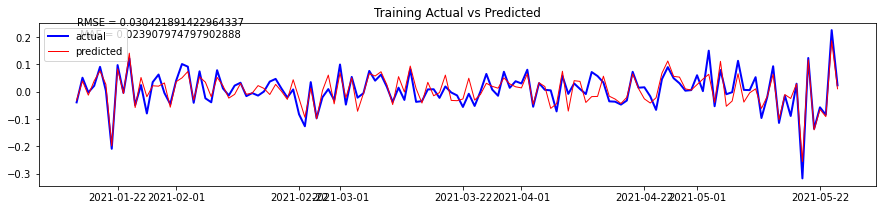

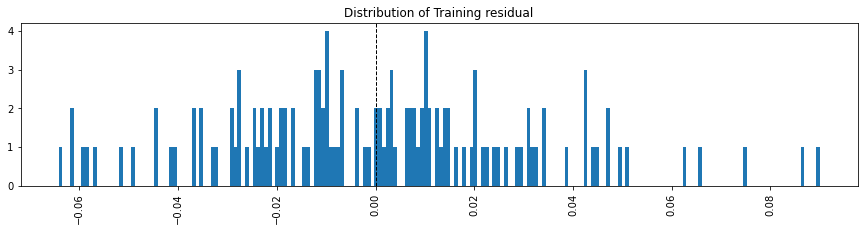

In [49]:
# graphs
model_graphs(predicted = train_predicted['price'], actual = train_actual['price'], title = 'Training')

In [50]:
# confusion matrix
train_confusion = confusion_matrix(predicted = train_predicted['price'], actual = train_actual['price'], title = 'Train')


Metrics for [Train]
Accuracy: 0.870 
TP Rate:  0.865 
FP Rate:  0.123
TN Rate:  0.877 
FN Rate:  0.135

            [Train] Confusion Matrix

           |-------------|-------------|
  n= 131  | Predicted:  | Predicted:  |
           |    Down     |    Up       |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|  Down    |  tn: 50    |  fp: 7    |    57     |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|   UP     |  fn: 10    |  tp: 64    |    74    |
|----------|-------------|-------------|------------|
           |             |             |
           |      60    |      71   |
           |-------------|-------------|



- ## test

In [51]:
# test results
# test_lag contains the last 'num_lag' number of observations of the training data in order to make the forecast for the first "real" test observation
test_lag = stationary.iloc[len(train) - num_lag :]
test_predicted = predict(data = test_lag, fitted_model = model_fit, lag_order = num_lag, predict_steps = 1)
test_actual = stationary.iloc[len(train) :]

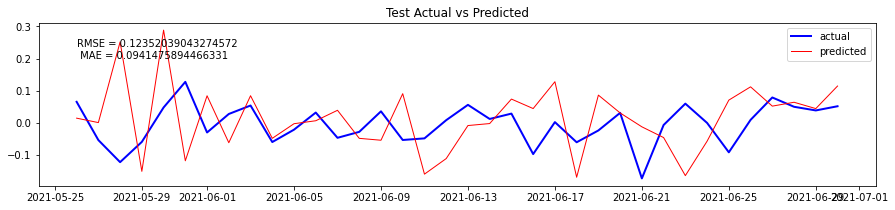

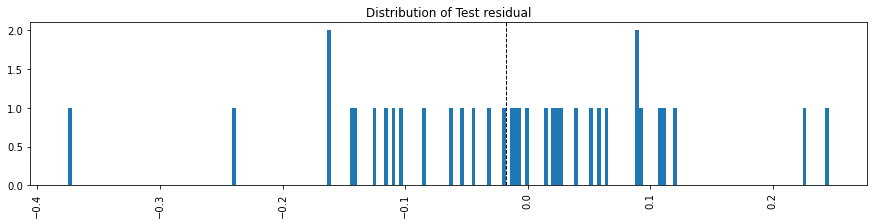

In [52]:
# graphs
model_graphs(predicted = test_predicted['price'], actual = test_actual['price'], title = 'Test')

In [53]:
# confusion matrix
test_confusion = confusion_matrix(predicted = test_predicted['price'], actual = test_actual['price'], title = 'Test')


Metrics for [Test]
Accuracy: 0.583 
TP Rate:  0.632 
FP Rate:  0.471
TN Rate:  0.529 
FN Rate:  0.368

            [Test] Confusion Matrix

           |-------------|-------------|
  n= 36  | Predicted:  | Predicted:  |
           |    Down     |    Up       |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|  Down    |  tn: 9    |  fp: 8    |    17     |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|   UP     |  fn: 7    |  tp: 12    |    19    |
|----------|-------------|-------------|------------|
           |             |             |
           |      16    |      20   |
           |-------------|-------------|



- ## persistent model

In [54]:
# persistent model data over test data
persistent_predicted = stationary.shift(1)
persistent_predicted = persistent_predicted.iloc[len(train) : ]
persistent_actual = test_actual.copy()

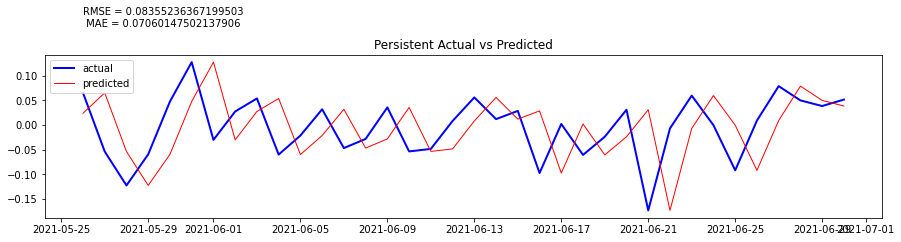

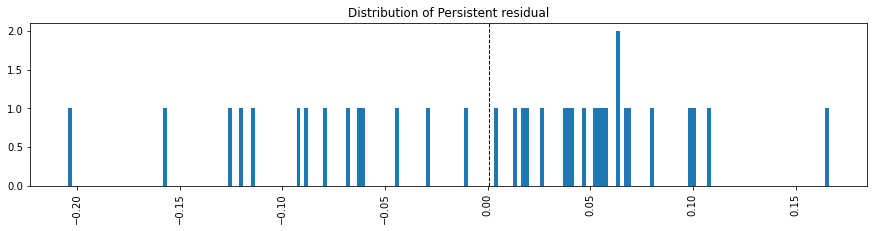

In [55]:
# graphs
model_graphs(predicted = persistent_predicted['price'], actual = persistent_actual['price'], title = 'Persistent')

In [56]:
# confusion matrix
persistent_confusion = confusion_matrix(predicted = persistent_predicted['price'], actual = persistent_actual['price'], title = 'Persistent')


Metrics for [Persistent]
Accuracy: 0.500 
TP Rate:  0.526 
FP Rate:  0.529
TN Rate:  0.471 
FN Rate:  0.474

            [Persistent] Confusion Matrix

           |-------------|-------------|
  n= 36  | Predicted:  | Predicted:  |
           |    Down     |    Up       |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|  Down    |  tn: 8    |  fp: 9    |    17     |
|----------|-------------|-------------|------------|
| Actual:  |             |             |            |
|   UP     |  fn: 9    |  tp: 10    |    19    |
|----------|-------------|-------------|------------|
           |             |             |
           |      17    |      19   |
           |-------------|-------------|

